# Trabajo práctico 7. Estabilidad de proteínas

In [1]:
%matplotlib inline

Importamos las bibliotecas necesarias

In [2]:
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from scipy.optimize import curve_fit
from math import factorial


Función de filtro Savitzky-Golay para hacer derivación numérica por aproximación polinómica y buscar máximos con precisión

In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    #import numpy as np
    #from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

Concentraciones de urea usadas (de la planilla)

In [4]:
concentracionesUrea=np.array([
0,
1,
1.6,
2.2,
2.6,
3,
3.4,
3.8,
4.2,
4.6,
5,
5.4,
5.8,
6.2,
6.6,
7,
7.4,
7.8,
8.4])

Espectros, hay que ordenarlos para poder asociarlos con la concentración de urea

In [5]:
espectros=[x for x in os.listdir(".") if "pleg" in x]
numero=[int(x.split(".")[0][4:]) for x in espectros]
ordenados=sorted([(x,y) for x,y in zip(numero,espectros)])
ureaEspectros=[(x,y[1]) for x,y in zip(concentracionesUrea,ordenados)]
espectrosOrdenados=[x[1] for x in ordenados]

In [6]:
ureaEspectros

[(0.0, 'pleg1.txt'),
 (1.0, 'pleg2.txt'),
 (1.6, 'pleg3.txt'),
 (2.2, 'pleg4.txt'),
 (2.6, 'pleg5.txt'),
 (3.0, 'pleg6.txt'),
 (3.4, 'pleg7.txt'),
 (3.8, 'pleg8.txt'),
 (4.2, 'pleg9.txt'),
 (4.6, 'pleg10.txt'),
 (5.0, 'pleg11.txt'),
 (5.4, 'pleg12.txt'),
 (5.8, 'pleg13.txt'),
 (6.2, 'pleg14.txt'),
 (6.6, 'pleg15.txt'),
 (7.0, 'pleg16.txt'),
 (7.4, 'pleg17.txt'),
 (7.8, 'pleg18.txt'),
 (8.4, 'pleg19.txt')]

In [7]:
columnas=[doble for x in espectrosOrdenados for doble in (x[:-4]+"_nm",x[:-4]+"_fluo")]

Diccionario con los datos para armar planilla de pandas

In [8]:
todosLosDatos=dict()
for u,e in ureaEspectros:
    archivo=open(e,"r").readlines()
    nm=[float(x.split()[0]) for x in archivo]
    fluo=[float(x.split()[1]) for x in archivo]
#     todosLosDatos["%.1f_nm"%u]=nm
    if not "nm" in "".join(todosLosDatos.keys()):
        #Supongo que todos los espectros tienen los mismos nm
        todosLosDatos["%.1f_nm"%u]=nm
    todosLosDatos["%.1f_fluo"%u]=fluo

In [9]:
planillaEspectros=pd.DataFrame(todosLosDatos)

In [10]:
planillaEspectros

,0.0_nm,0.0_fluo,1.0_fluo,1.6_fluo,2.2_fluo,2.6_fluo,3.0_fluo,3.4_fluo,3.8_fluo,4.2_fluo,4.6_fluo,5.0_fluo,5.4_fluo,5.8_fluo,6.2_fluo,6.6_fluo,7.0_fluo,7.4_fluo,7.8_fluo,8.4_fluo
0,300.0,0.167,0.192,0.176,0.186,0.165,0.180,0.161,0.144,0.143,0.134,0.123,0.127,0.121,0.136,0.125,0.132,0.104,0.135,0.127
1,301.0,0.184,0.210,0.194,0.204,0.182,0.196,0.176,0.158,0.157,0.146,0.134,0.137,0.131,0.147,0.136,0.143,0.113,0.145,0.136
2,302.0,0.203,0.231,0.210,0.222,0.197,0.215,0.193,0.172,0.171,0.159,0.145,0.150,0.142,0.160,0.146,0.155,0.122,0.158,0.148
3,303.0,0.220,0.249,0.228,0.242,0.214,0.231,0.208,0.187,0.186,0.174,0.158,0.162,0.154,0.173,0.159,0.169,0.132,0.170,0.159
4,304.0,0.240,0.270,0.244,0.259,0.230,0.251,0.227,0.201,0.201,0.188,0.171,0.177,0.168,0.188,0.171,0.182,0.142,0.185,0.173
5,305.0,0.258,0.289,0.263,0.279,0.248,0.269,0.244,0.218,0.219,0.205,0.186,0.191,0.181,0.203,0.186,0.198,0.153,0.199,0.186
6,306.0,0.279,0.310,0.279,0.297,0.264,0.290,0.263,0.234,0.236,0.221,0.201,0.208,0.197,0.222,0.201,0.213,0.165,0.216,0.201
7,307.0,0.297,0.330,0.298,0.317,0.282,0.308,0.281,0.252,0.256,0.240,0.218,0.224,0.212,0.239,0.218,0.231,0.178,0.233,0.216
8,308.0,0.318,0.351,0.314,0.335,0.298,0.329,0.301,0.269,0.274,0.258,0.234,0.244,0.230,0.260,0.234,0.249,0.191,0.252,0.235
9,309.0,0.336,0.370,0.332,0.355,0.317,0.348,0.319,0.288,0.296,0.279,0.254,0.261,0.247,0.279,0.253,0.269,0.206,0.270,0.251


In [11]:
planillaEspectros.columns

Index(['0.0_nm', '0.0_fluo', '1.0_fluo', '1.6_fluo', '2.2_fluo', '2.6_fluo',
       '3.0_fluo', '3.4_fluo', '3.8_fluo', '4.2_fluo', '4.6_fluo', '5.0_fluo',
       '5.4_fluo', '5.8_fluo', '6.2_fluo', '6.6_fluo', '7.0_fluo', '7.4_fluo',
       '7.8_fluo', '8.4_fluo'],
      dtype='object')

pongo los nm y los espectros en arrays de numpy

In [12]:
nm=np.array(planillaEspectros["0.0_nm"])
espFluo=np.array([planillaEspectros[x] for x in planillaEspectros.columns if "fluo" in x])

Letras grandes en matplotlib

In [13]:
pl.rcParams.update({'font.size': 14})

Gráfico de los espectros con gradiente de color

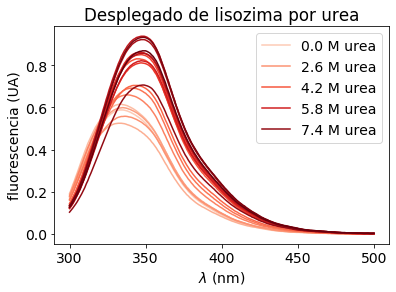

In [14]:
colores=np.linspace(0.2,1, len(espFluo))
for i,e in enumerate(espFluo):
    if i%4==0:
        pl.plot(nm,e,color=pl.cm.Reds(colores[i]),label="%.1f M urea"%concentracionesUrea[i])
    else:
        pl.plot(nm,e,color=pl.cm.Reds(colores[i]))
pl.xlabel(r"$\lambda $ (nm)")
pl.ylabel("fluorescencia (UA)")
pl.title("Desplegado de lisozima por urea")
pl.legend()
pl.savefig("espectros.pdf",bbox_inches='tight')

La intensidad de fluorescencia
+ aumenta cuando se despliega la proteína
+ se corre al rojo

Probamos primero lo más directo: buscar adónde difieren más los espectros y seguir la fluorescencia durante el desplegado en ese punto

La diferencia máxima está en el punto 57 a 357.0 nm


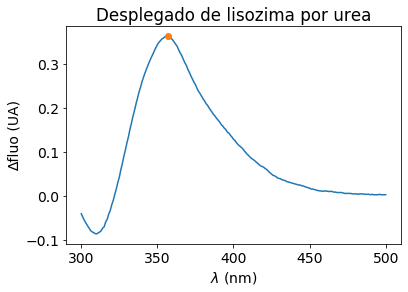

In [15]:
pl.plot(nm,espFluo[-1]-espFluo[0])
posMax=np.argmax(espFluo[-1]-espFluo[0])
pl.plot(nm[posMax],espFluo[-1][posMax]-espFluo[0][posMax],"o")
pl.xlabel(r"$\lambda $ (nm)")
pl.ylabel("∆fluo (UA)")
pl.title("Desplegado de lisozima por urea")
print("La diferencia máxima está en el punto %i a %.1f nm"%(posMax,nm[posMax]))
pl.savefig("diferencia.pdf",bbox_inches='tight')

In [16]:
espFluo.shape

(19, 201)

Gráfico de la intensidad de fluorescencia en el máximo vs. [urea]

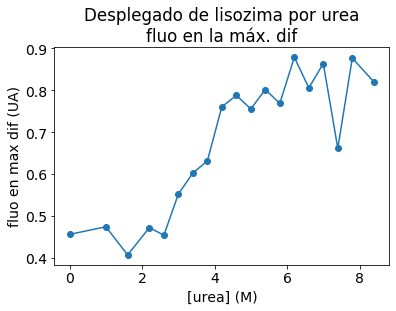

In [17]:
fluosEnMaxDif=espFluo[:,posMax]
pl.plot(concentracionesUrea,fluosEnMaxDif,"o-")
pl.xlabel("[urea] (M)")
pl.ylabel("fluo en max dif (UA)")
pl.title("Desplegado de lisozima por urea\nfluo en la máx. dif")
pl.savefig("IfEnDifMax.pdf",bbox_inches='tight')


Razonable, se ve una transición cooperativa entre 3 y 5 M urea, aproximadamente. Pero las lineas de tendencia a baja y alta urea son muy ruidosas (probablemente la transición también pero no se nota tanto...)

Planilla de pandas para guardar los datos analizados

In [18]:
datosParaPlanilla={
    "[urea]":concentracionesUrea,
    "fluo en max. dif":fluosEnMaxDif
}
planillaAnalisis=pd.DataFrame(datosParaPlanilla)

In [19]:
planillaAnalisis

,[urea],fluo en max. dif
0,0.0,0.457
1,1.0,0.475
2,1.6,0.408
3,2.2,0.473
4,2.6,0.455
5,3.0,0.553
6,3.4,0.603
7,3.8,0.632
8,4.2,0.761
9,4.6,0.788


Una señal en un punto puede ser ruidosa. Probamos integrando la fluorescencia alrededor del máximo para mejorar la relación señal/ruido

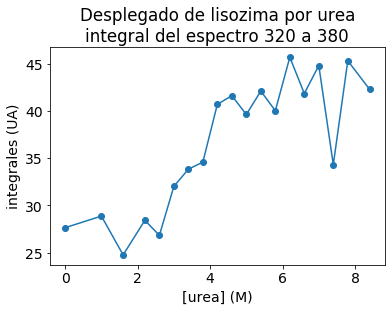

In [20]:
lugar320=np.where(nm==320)[0][0]
lugar380=np.where(nm==380)[0][0]
integrales320_380=np.sum(espFluo[:,lugar320:lugar380],axis=1)
pl.plot(concentracionesUrea,integrales320_380,"o-")
pl.xlabel("[urea] (M)")
pl.ylabel("integrales (UA)")
pl.title("Desplegado de lisozima por urea\nintegral del espectro 320 a 380")
pl.savefig("integ_320-380.pdf",bbox_inches='tight')

No mejora mucho...

In [21]:
planillaAnalisis.loc[:,'integrales 320-380'] = pd.Series(integrales320_380, index=planillaAnalisis.index)

Integrando los espectros completos

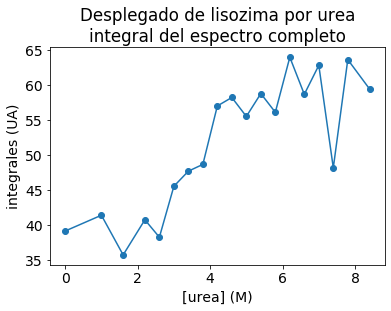

In [22]:
integralesEnteras=np.sum(espFluo,axis=1)
pl.plot(concentracionesUrea,integralesEnteras,"o-")
pl.xlabel("[urea] (M)")
pl.ylabel("integrales (UA)")
pl.title("Desplegado de lisozima por urea\nintegral del espectro completo")
pl.savefig("integTotal.pdf",bbox_inches='tight')

Peor

In [23]:
planillaAnalisis.loc[:,'integrales completas'] = pd.Series(integralesEnteras, index=planillaAnalisis.index)

¿Qué pasa si en vez de seguir la fluorescencia a longitud de onda fija seguimos la fluorescencia en el máximo de la curva?

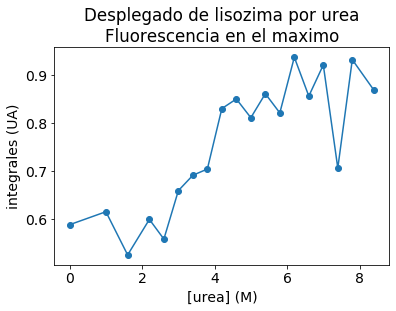

In [24]:
posMaxTodos=np.argmax(espFluo,axis=1)
fluoEnMax=np.array([e[p] for e,p in zip(espFluo,posMaxTodos)])
pl.plot(concentracionesUrea,fluoEnMax,"o-")
pl.xlabel("[urea] (M)")
pl.ylabel("integrales (UA)")
pl.title("Desplegado de lisozima por urea\nFluorescencia en el maximo")
pl.savefig("IfEnMax.pdf",bbox_inches='tight')

In [25]:
planillaAnalisis.loc[:,'fluorescencia en el maximo'] = pd.Series(fluoEnMax, index=planillaAnalisis.index)

Sigue siedno feo. Pero ahora que sabemos el máximo, veamos como se corre

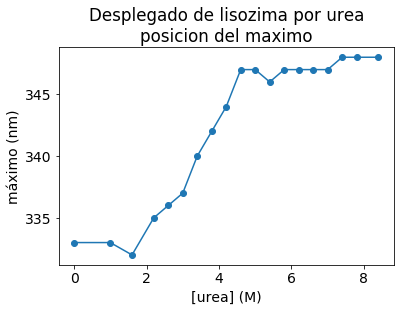

In [26]:
nmMaxTodos=nm[posMaxTodos]
pl.plot(concentracionesUrea,nmMaxTodos,"o-")
pl.xlabel("[urea] (M)")
pl.ylabel("máximo (nm)")
pl.title("Desplegado de lisozima por urea\nposicion del maximo")
pl.savefig("posMax.pdf",bbox_inches='tight')

In [27]:
planillaAnalisis.loc[:,'posicion del maximo'] = pd.Series(nmMaxTodos, index=planillaAnalisis.index)

¡Bastante mejor! Pero los datos estan dados en nm enteros, así que la posición se redondea y da lugar a una suerte de "escalones" en la curva (notables sobre todo en las tendencias del principio y del final

Para buscar el máximo con más precisión, usamos el algoritmo de Savitzky-Golay:
+ Ajustamos el espectro por ventanas a un polinomio
+ Calculamos la derivada primera del polinomio ajustado y se la asignamos al punto central de la ventana
+ Buscamos el lugar adonde la derivada primera se hace negativa
+ Interpolamos la posición entre el último punto positivo y el primero negativo y tenemos un máximo con mayor precisión numerica

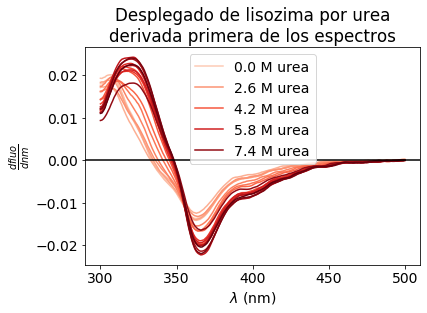

In [58]:
datosDerivadas=dict()
datosDerivadas["nm"]=nm
ventanaFiltro=9
colores=np.linspace(0.2,1, len(espFluo))
for i,e in enumerate(espFluo):
    derivada=savitzky_golay(e,ventanaFiltro,2,1)
    if i%4==0:
        pl.plot(nm,derivada,
                color=pl.cm.Reds(colores[i]),
                label="%.1f M urea"%concentracionesUrea[i])
    else:
        pl.plot(nm,derivada,
                color=pl.cm.Reds(colores[i]))
    datosDerivadas["%.1f_d1"%concentracionesUrea[i]]=derivada
pl.xlabel(r"$\lambda $ (nm)")
pl.ylabel(r"$ \frac{dfluo}{dnm} $")
pl.title("Desplegado de lisozima por urea\nderivada primera de los espectros")
pl.axhline(color="k")
pl.legend()
pl.savefig("espectrosD1.pdf",bbox_inches='tight')

In [59]:
planillaDerivadas=pd.DataFrame(datosDerivadas)

Hacemos zoom en la región que corta el eje 0

0.0 = 334.09 nm
1.0 = 333.56 nm
1.6 = 333.00 nm
2.2 = 334.76 nm
2.6 = 336.16 nm
3.0 = 338.00 nm
3.4 = 341.08 nm
3.8 = 343.50 nm
4.2 = 345.38 nm
4.6 = 346.50 nm
5.0 = 347.17 nm
5.4 = 346.35 nm
5.8 = 347.45 nm
6.2 = 347.71 nm
6.6 = 347.69 nm
7.0 = 347.73 nm
7.4 = 348.02 nm
7.8 = 348.04 nm
8.4 = 348.40 nm


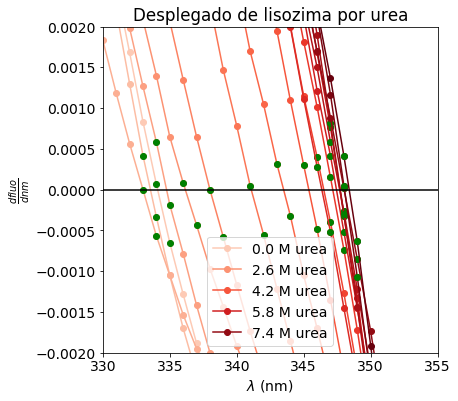

In [29]:
maximosPrecisos=[]
ventanaFiltro=9
colores=np.linspace(0.2,1, len(espFluo))
for i,e in enumerate(espFluo):
    if i%4==0:
        pl.plot(nm,savitzky_golay(e,ventanaFiltro,2,1),
                "o-",
                color=pl.cm.Reds(colores[i]),
                label="%.1f M urea"%concentracionesUrea[i])
    else:
        pl.plot(nm,savitzky_golay(e,ventanaFiltro,2,1),
                "o-",
                color=pl.cm.Reds(colores[i])
               )
    d1=savitzky_golay(e,ventanaFiltro,2,1)
    posPuntoMasAlt=np.argmax(e)
    cruzaCero=np.argmax(d1<0)
    nmCruzaCero=nm[cruzaCero]
    nmAntesCero=nm[cruzaCero-1]
    d1DespuesCero=d1[cruzaCero]
    d1AntesCero=d1[cruzaCero-1]
    pl.plot(nmCruzaCero,d1DespuesCero,"go")
    pl.plot(nmAntesCero,d1AntesCero,"go")
    nmPrecis=nmAntesCero+d1AntesCero*(nmCruzaCero-nmAntesCero)/(d1AntesCero-d1DespuesCero)
    maximosPrecisos.append(nmPrecis)
    
    print("%.1f = %.2f nm"%(concentracionesUrea[i],nmPrecis))

maximos_d1=np.array(maximosPrecisos)
pl.xlabel(r"$\lambda $ (nm)")
pl.ylabel(r"$ \frac{dfluo}{dnm} $")
pl.xlim(330,355)
pl.ylim(-.002,.002)
pl.axhline(color="k")
pl.title("Desplegado de lisozima por urea")
pl.legend()
fig=pl.gcf()
fig.set_size_inches(6,6)
pl.savefig("d1Cruce.pdf",bbox_inches='tight')

Graficamos el máximo preciso

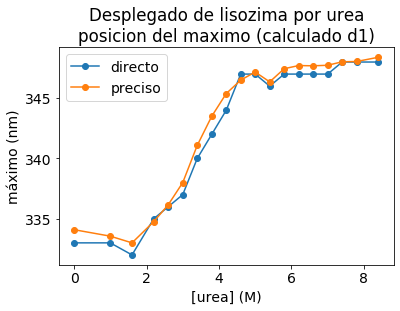

In [30]:
pl.plot(concentracionesUrea,nmMaxTodos,"o-", label="directo")
pl.plot(concentracionesUrea,maximos_d1,"o-", label="preciso")
pl.xlabel("[urea] (M)")
pl.ylabel("máximo (nm)")
pl.legend()
pl.title("Desplegado de lisozima por urea\nposicion del maximo (calculado d1)")
pl.savefig("maxVsD1.pdf",bbox_inches='tight')

In [31]:
planillaAnalisis.loc[:,'maximo derivada'] = pd.Series(maximos_d1, index=planillaAnalisis.index)

Trabajo sobre la curva "precisa". Tomo para las lineas de tendencia los primeros 4 puntos y los últimos 10

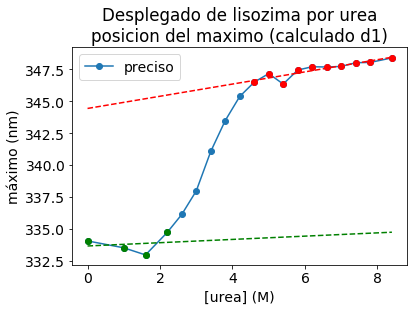

In [32]:
numIni=4
numFin=10
tendenciaIni=maximos_d1[:numIni]
ureaIni=concentracionesUrea[:numIni]
tendenciaFin=maximos_d1[-numFin:]
ureaFin=concentracionesUrea[-numFin:]
mIni, hIni=np.polyfit(ureaIni,tendenciaIni,1)
mFin, hFin=np.polyfit(ureaFin,tendenciaFin,1)
lineaIni=mIni*concentracionesUrea+hIni
lineaFin=mFin*concentracionesUrea+hFin
pl.plot(concentracionesUrea,maximos_d1,"o-", label="preciso")
pl.plot(ureaIni,tendenciaIni,"go")
pl.plot(ureaFin,tendenciaFin,"ro")
pl.plot(concentracionesUrea,lineaIni,"g--")
pl.plot(concentracionesUrea,lineaFin,"r--")
pl.xlabel("[urea] (M)")
pl.ylabel("máximo (nm)")
pl.legend()
pl.title("Desplegado de lisozima por urea\nposicion del maximo (calculado d1)")
pl.savefig("tendenciaD1.pdf",bbox_inches='tight')

In [33]:
datosAjuste={
    "[urea]":concentracionesUrea,
    "maximo derivada":maximos_d1,
    "tendencia fin max d1":lineaFin,
    "tendencia ini max d1":lineaIni    
}
planillaAjusteMaxD1=pd.DataFrame(datosAjuste)


Cálculo de fracción desplegada. Interpolo el valor de cada punto experimental entre las rectas iniciales y finales

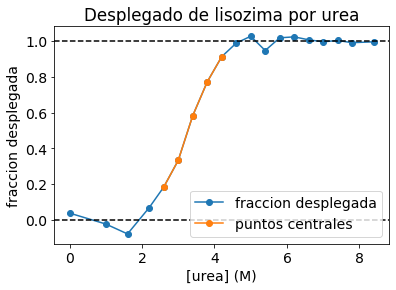

In [34]:
fU=(maximos_d1-lineaIni)/(lineaFin-lineaIni)
fUCentrales=fU[numIni:-numFin]
ureaCentrales=concentracionesUrea[numIni:-numFin]
pl.plot(concentracionesUrea,fU,"o-", label="fraccion desplegada")
pl.plot(ureaCentrales,fUCentrales,"o-", label="puntos centrales")
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--")
pl.axhline(y=1,color="k",linestyle="--")
pl.title("Desplegado de lisozima por urea")
pl.savefig("fUD1.pdf",bbox_inches='tight')

In [35]:
planillaAjusteMaxD1.loc[:,'frac. desp.'] = pd.Series(fU, index=planillaAnalisis.index)

Calculo ∆G en los puntos centrales y exgrapolo

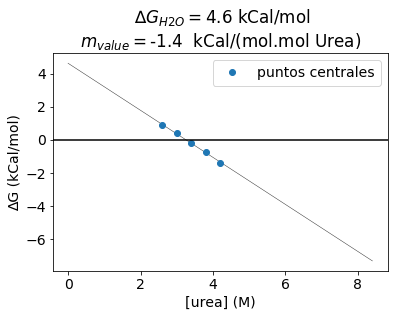

In [36]:
kEq=fUCentrales/(1-fUCentrales)
R=1.99e-3 #kcal/mol.K
T=298 #K
deltaG=-R*T*np.log(kEq)
mValue,dGH2O=np.polyfit(ureaCentrales,deltaG,1)
lineaDG=mValue*concentracionesUrea+dGH2O
pl.plot(concentracionesUrea,lineaDG,"k-",linewidth=0.5,alpha=0.8)
pl.plot(ureaCentrales,deltaG,"o",
        label="puntos centrales")
pl.axhline(color="k")
pl.xlabel("[urea] (M)")
pl.ylabel("∆G (kCal/mol)")
pl.title(
    r""" $ ∆G_{H2O}= $%.1f kCal/mol 
$ m_{value}= $%.1f  kCal/(mol.mol Urea)"""%(dGH2O,mValue))
pl.legend()
pl.savefig("DGD1.pdf",bbox_inches='tight')

In [37]:
prefill=np.zeros(numIni)
prefill[:]=np.nan
postFill=np.zeros(numFin)
postFill[:]=np.nan
dGparaPandas=np.concatenate([prefill,deltaG,postFill])
planillaAjusteMaxD1.loc[:,'deltaG'] = pd.Series(dGparaPandas, index=planillaAnalisis.index)
planillaAjusteMaxD1.loc[:,'deltaG calc'] = pd.Series(lineaDG, index=planillaAnalisis.index)


Con estos valores podemos calcular la curva de equilibrio

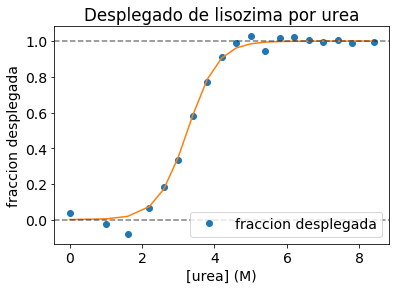

In [38]:
kEqCalc=np.exp(-lineaDG/(R*T))
fUCalc=kEqCalc/(1+kEqCalc)
pl.plot(concentracionesUrea,fU,"o", label="fraccion desplegada")
pl.plot(concentracionesUrea,fUCalc)
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--", alpha=0.5)
pl.axhline(y=1,color="k",linestyle="--", alpha=0.5)
pl.title("Desplegado de lisozima por urea")
pl.savefig("ajusteD1.pdf",bbox_inches='tight')

In [39]:
planillaAjusteMaxD1.loc[:,'frac. desp. calc'] = pd.Series(fUCalc, index=planillaAnalisis.index)


Repito pero usando los datos de máximo directo

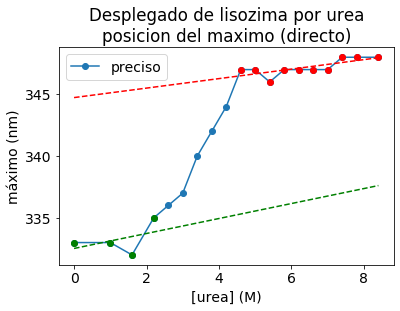

In [40]:
numIni=4
numFin=10
tendenciaIni=nmMaxTodos[:numIni]
ureaIni=concentracionesUrea[:numIni]
tendenciaFin=nmMaxTodos[-numFin:]
ureaFin=concentracionesUrea[-numFin:]
mIni, hIni=np.polyfit(ureaIni,tendenciaIni,1)
mFin, hFin=np.polyfit(ureaFin,tendenciaFin,1)
lineaIni=mIni*concentracionesUrea+hIni
lineaFin=mFin*concentracionesUrea+hFin
pl.plot(concentracionesUrea,nmMaxTodos,"o-", label="preciso")
pl.plot(ureaIni,tendenciaIni,"go")
pl.plot(ureaFin,tendenciaFin,"ro")
pl.plot(concentracionesUrea,lineaIni,"g--")
pl.plot(concentracionesUrea,lineaFin,"r--")
pl.xlabel("[urea] (M)")
pl.ylabel("máximo (nm)")
pl.legend()
pl.title("Desplegado de lisozima por urea\nposicion del maximo (directo)")
pl.savefig("tendenciaMax.pdf",bbox_inches='tight')

In [41]:
datosAjuste2={
    "[urea]":concentracionesUrea,
    "maximo":nmMaxTodos,
    "tendencia fin max d1":lineaFin,
    "tendencia ini max d1":lineaIni    
}
planillaAjusteMax=pd.DataFrame(datosAjuste2)


Cálculo de fracción desplegada. Interpolo el valor de cada punto experimental entre las rectas iniciales y finales

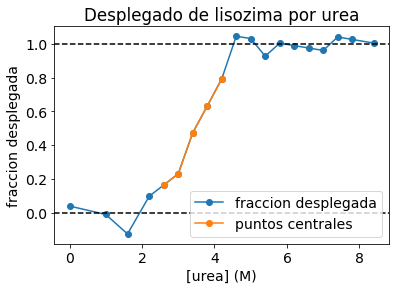

In [42]:
fU=(nmMaxTodos-lineaIni)/(lineaFin-lineaIni)
fUCentrales=fU[numIni:-numFin]
ureaCentrales=concentracionesUrea[numIni:-numFin]
pl.plot(concentracionesUrea,fU,"o-", label="fraccion desplegada")
pl.plot(ureaCentrales,fUCentrales,"o-", label="puntos centrales")
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--")
pl.axhline(y=1,color="k",linestyle="--")
pl.title("Desplegado de lisozima por urea")
pl.savefig("fUmax.pdf",bbox_inches='tight')

In [43]:
planillaAjusteMax.loc[:,'frac. desp.'] = pd.Series(fU, index=planillaAnalisis.index)

Calculo ∆G en los puntos centrales y exgrapolo

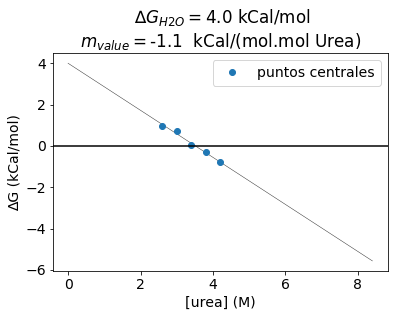

In [44]:
kEq=fUCentrales/(1-fUCentrales)
R=1.99e-3 #kcal/mol.K
T=298 #K
deltaG=-R*T*np.log(kEq)
mValue,dGH2O=np.polyfit(ureaCentrales,deltaG,1)
lineaDG=mValue*concentracionesUrea+dGH2O
pl.plot(concentracionesUrea,lineaDG,"k-",linewidth=0.5,alpha=0.8)
pl.plot(ureaCentrales,deltaG,"o",
        label="puntos centrales")
pl.axhline(color="k")
pl.xlabel("[urea] (M)")
pl.ylabel("∆G (kCal/mol)")
pl.title(
    r""" $ ∆G_{H2O}= $%.1f kCal/mol 
$ m_{value}= $%.1f  kCal/(mol.mol Urea)"""%(dGH2O,mValue))
pl.legend()
pl.savefig("DGmax.pdf",bbox_inches='tight')

In [45]:
prefill=np.zeros(numIni)
prefill[:]=np.nan
postFill=np.zeros(numFin)
postFill[:]=np.nan
dGparaPandas=np.concatenate([prefill,deltaG,postFill])
planillaAjusteMax.loc[:,'deltaG'] = pd.Series(dGparaPandas, index=planillaAnalisis.index)
planillaAjusteMax.loc[:,'deltaG calc'] = pd.Series(lineaDG, index=planillaAnalisis.index)


Con estos valores podemos calcular la curva de equilibrio

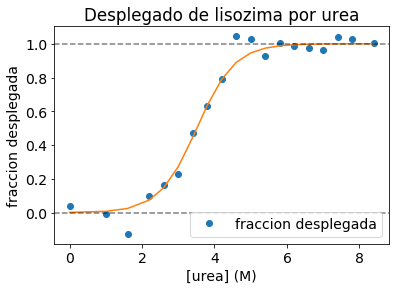

In [46]:
kEqCalc=np.exp(-lineaDG/(R*T))
fUCalc=kEqCalc/(1+kEqCalc)
pl.plot(concentracionesUrea,fU,"o", label="fraccion desplegada")
pl.plot(concentracionesUrea,fUCalc)
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--", alpha=0.5)
pl.axhline(y=1,color="k",linestyle="--", alpha=0.5)
pl.title("Desplegado de lisozima por urea")
pl.savefig("ajusteMax.pdf",bbox_inches='tight')


In [47]:
planillaAjusteMax.loc[:,'frac. desp. calc'] = pd.Series(fUCalc, index=planillaAnalisis.index)


Repito pero usando los datos de intensidad de fluorescencia a 357 nm

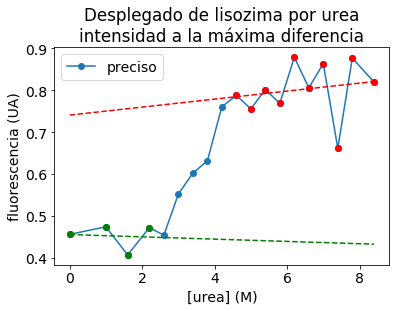

In [48]:
numIni=4
numFin=10
tendenciaIni=fluosEnMaxDif[:numIni]
ureaIni=concentracionesUrea[:numIni]
tendenciaFin=fluosEnMaxDif[-numFin:]
ureaFin=concentracionesUrea[-numFin:]
mIni, hIni=np.polyfit(ureaIni,tendenciaIni,1)
mFin, hFin=np.polyfit(ureaFin,tendenciaFin,1)
lineaIni=mIni*concentracionesUrea+hIni
lineaFin=mFin*concentracionesUrea+hFin
pl.plot(concentracionesUrea,fluosEnMaxDif,"o-", label="preciso")
pl.plot(ureaIni,tendenciaIni,"go")
pl.plot(ureaFin,tendenciaFin,"ro")
pl.plot(concentracionesUrea,lineaIni,"g--")
pl.plot(concentracionesUrea,lineaFin,"r--")
pl.xlabel("[urea] (M)")
pl.ylabel("fluorescencia (UA)")
pl.legend()
pl.title("Desplegado de lisozima por urea\nintensidad a la máxima diferencia")
pl.savefig("tendenciaIF.pdf",bbox_inches='tight')

In [49]:
datosAjuste3={
    "[urea]":concentracionesUrea,
    "fluo dif max":fluosEnMaxDif,
    "tendencia fin":lineaFin,
    "tendencia ini":lineaIni    
}
planillaAjusteIF=pd.DataFrame(datosAjuste3)


Cálculo de fracción desplegada. Interpolo el valor de cada punto experimental entre las rectas iniciales y finales

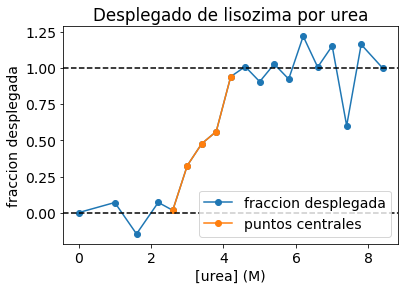

In [50]:
fU=(fluosEnMaxDif-lineaIni)/(lineaFin-lineaIni)
fUCentrales=fU[numIni:-numFin]
ureaCentrales=concentracionesUrea[numIni:-numFin]
pl.plot(concentracionesUrea,fU,"o-", label="fraccion desplegada")
pl.plot(ureaCentrales,fUCentrales,"o-", label="puntos centrales")
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--")
pl.axhline(y=1,color="k",linestyle="--")
pl.title("Desplegado de lisozima por urea")
pl.savefig("fUIf.pdf",bbox_inches='tight')

In [51]:
planillaAjusteIF.loc[:,'frac. desp.'] = pd.Series(fU, index=planillaAnalisis.index)

Calculo ∆G en los puntos centrales y exgrapolo

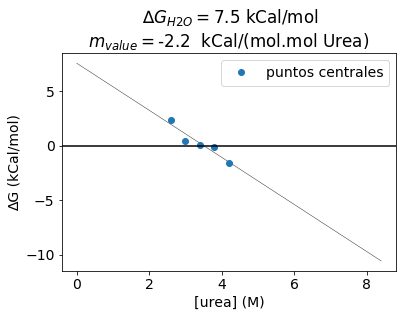

In [52]:
kEq=fUCentrales/(1-fUCentrales)
R=1.99e-3 #kcal/mol.K
T=298 #K
deltaG=-R*T*np.log(kEq)
mValue,dGH2O=np.polyfit(ureaCentrales,deltaG,1)
lineaDG=mValue*concentracionesUrea+dGH2O
pl.plot(concentracionesUrea,lineaDG,"k-",linewidth=0.5,alpha=0.8)
pl.plot(ureaCentrales,deltaG,"o",
        label="puntos centrales")
pl.axhline(color="k")
pl.xlabel("[urea] (M)")
pl.ylabel("∆G (kCal/mol)")
pl.title(
    r""" $ ∆G_{H2O}= $%.1f kCal/mol 
$ m_{value}= $%.1f  kCal/(mol.mol Urea)"""%(dGH2O,mValue))
pl.legend()
pl.savefig("DGIf.pdf",bbox_inches='tight')

In [53]:
prefill=np.zeros(numIni)
prefill[:]=np.nan
postFill=np.zeros(numFin)
postFill[:]=np.nan
dGparaPandas=np.concatenate([prefill,deltaG,postFill])
planillaAjusteIF.loc[:,'deltaG'] = pd.Series(dGparaPandas, index=planillaAnalisis.index)
planillaAjusteIF.loc[:,'deltaG calc'] = pd.Series(lineaDG, index=planillaAnalisis.index)


Con estos valores podemos calcular la curva de equilibrio

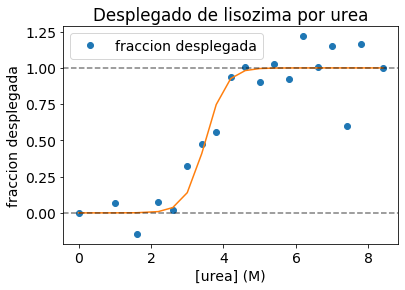

In [54]:
kEqCalc=np.exp(-lineaDG/(R*T))
fUCalc=kEqCalc/(1+kEqCalc)
pl.plot(concentracionesUrea,fU,"o", label="fraccion desplegada")
pl.plot(concentracionesUrea,fUCalc)
pl.xlabel("[urea] (M)")
pl.ylabel("fraccion desplegada")
pl.legend()
pl.axhline(color="k",linestyle="--", alpha=0.5)
pl.axhline(y=1,color="k",linestyle="--", alpha=0.5)
pl.title("Desplegado de lisozima por urea")
pl.savefig("ajusteIF.pdf",bbox_inches='tight')

In [55]:
planillaAjusteIF.loc[:,'frac. desp. calc'] = pd.Series(fUCalc, index=planillaAnalisis.index)

In [60]:
writer = pd.ExcelWriter('analizados.xlsx')
planillaEspectros.to_excel(writer,'Espectros')
planillaAnalisis.to_excel(writer,"Analisis")
planillaAjusteIF.to_excel(writer,"Ajuste IF")
planillaAjusteMax.to_excel(writer,"Ajuste max")
planillaDerivadas.to_excel(writer,'Derivadas')
planillaAjusteMaxD1.to_excel(writer,"Ajuste max d1")
writer.save()